# Stock Price Prediction
inspired/base by https://www.youtube.com/watch?v=QIUxPv5PJOY&list=WL&index=7&t=225s

# Imports

In [1]:
import math
import pandas as pd
import numpy as np

import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

#plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

print("Import successful")

#if you dont like the warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Import successful


# Processing data
Loading stock data from yahoo.

In [2]:
df=web.DataReader("MS", data_source="yahoo", start="2010-01-01", end = "2020-08-01")
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,31.969999,30.629999,30.700001,30.910000,20371000.0,25.759523
2010-01-05,32.130001,30.930000,31.010000,32.040001,22523400.0,26.701244
2010-01-06,32.590000,31.790001,31.969999,32.450001,17028500.0,27.042919
2010-01-07,33.270000,32.270000,32.459999,32.919998,18693000.0,27.434603
2010-01-08,32.820000,31.980000,32.599998,32.250000,15993400.0,26.876251
...,...,...,...,...,...,...
2020-07-27,51.570000,49.730000,49.910000,51.320000,12087100.0,50.964951
2020-07-28,51.220001,50.209999,50.830002,50.259998,7287900.0,49.912281
2020-07-29,50.660000,49.880001,50.270000,50.590000,8074300.0,50.240002


In [3]:
df = df[["High", "Low", "Close", "Volume", "Adj Close", "Open"]] #reordering to make things easier
df

,High,Low,Close,Volume,Adj Close,Open
Date,,,,,,
2010-01-04,31.969999,30.629999,30.910000,20371000.0,25.759523,30.700001
2010-01-05,32.130001,30.930000,32.040001,22523400.0,26.701244,31.010000
2010-01-06,32.590000,31.790001,32.450001,17028500.0,27.042919,31.969999
2010-01-07,33.270000,32.270000,32.919998,18693000.0,27.434603,32.459999
2010-01-08,32.820000,31.980000,32.250000,15993400.0,26.876251,32.599998
...,...,...,...,...,...,...
2020-07-27,51.570000,49.730000,51.320000,12087100.0,50.964951,49.910000
2020-07-28,51.220001,50.209999,50.259998,7287900.0,49.912281,50.830002
2020-07-29,50.660000,49.880001,50.590000,8074300.0,50.240002,50.270000


In [4]:
dataSet=df.values #creates numpy array
print(type(dataSet))
TrainDataLen=math.ceil(len(dataSet)*.8)

<class 'numpy.ndarray'>


In [5]:
#creating dataframe for plotting(before scaling)
plotdata=df[0:TrainDataLen]  # only plot with train(as it is the data we should know)
plotdata["nextOpen"]=plotdata["Open"]
for i in range(1,TrainDataLen-1):#wrong for 1. and last but thats fine with me
         plotdata["nextOpen"][i]=plotdata["nextOpen"][i+1]

In [6]:
#scaling to (0,1)
scaler=MinMaxScaler(feature_range=(0,1))
scaledData=scaler.fit_transform(dataSet)

In [7]:
#splitting the data in train and test
TrainData=scaledData[0:TrainDataLen]
TestData=scaledData[TrainDataLen -60: ]
TrainData[0]

array([0.4128106 , 0.40557802, 0.39849624, 0.24539034, 0.33316318,
       0.39729502])

In [8]:
xTrain=[]#past x days
yTrain=[]#prediction target

for i in range(60, len(TrainData)): #give 60 days of data=> predict 61th day
    xTrain.append(TrainData[i-60:i])
    yTrain.append(TrainData[i, 5])
    
xTest=[]
yTest=[]
for i in range(60, len(TestData)): #give 60 days of data=> predict 61th day
    xTest.append(TestData[i-60:i])
    yTest.append(TrainData[i, 5])
    
xTrain, yTrain=np.array(xTrain), np.array(yTrain)    
xTest, yTest=np.array(xTest), np.array(yTest)

print("xTrain Type:",type(xTrain), "\t xTest Type:",type(xTest),
      "\tyTrain Type:",type(yTrain[0]),"\tyTest Type:",type(yTest[0]),)
print("xTrain Len:",len(xTrain[0]), "\t xTest Len:",len(xTest[0])) #=60* 6 attr

xTrain Type: <class 'numpy.ndarray'> 	 xTest Type: <class 'numpy.ndarray'> 	yTrain Type: <class 'numpy.float64'> 	yTest Type: <class 'numpy.float64'>
xTrain Len: 60 	 xTest Len: 60


In [9]:
xTrain.shape

(2071, 60, 6)

In [10]:
xTest.shape

(532, 60, 6)

In [11]:
# #the lstm model expects 3 dim  but xtrain has only 2
# xTrain=np.reshape(xTrain,(xTrain.shape[0], xTrain.shape[1], 1))

# Plot

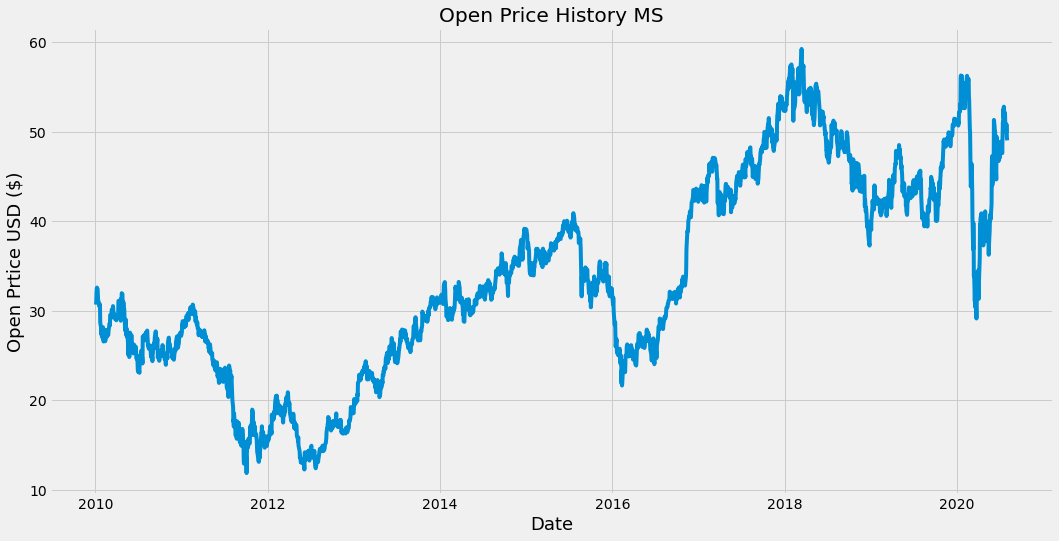

In [12]:
plt.figure(figsize=(16,8))
plt.title("Open Price History MS")
plt.plot(df["Open"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Open Prtice USD ($)", fontsize=18)
plt.show()  #useless

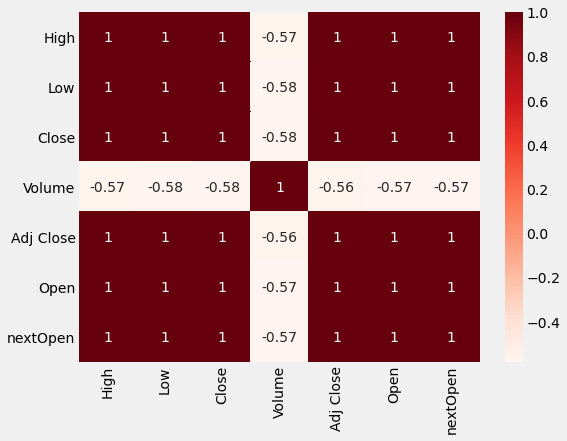

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(plotdata.corr(),annot=True,cmap='Reds')
 #obviously the values correlate (but to confirm)

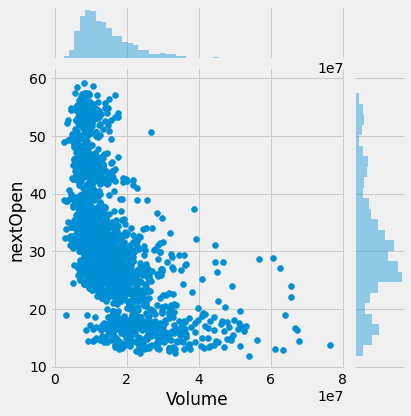

In [14]:
sns.jointplot(x="Volume", y="nextOpen", data=plotdata)

# Model

In [15]:
model=Sequential()
Neurons1=128
Neurons2=50 #more did not rly improve the results
model.add(LSTM(Neurons1,return_sequences=True, input_shape=xTrain[0].shape))# , input_shape=(xTrain.shape[1],1)
model.add(LSTM(Neurons2,return_sequences=False))
model.add(Dense(25, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="MSE", metrics=["MSE"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 128)           69120     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 106,221
Trainable params: 106,221
Non-trainable params: 0
_________________________________________________________________


# Training

In [16]:
try:
    # uncomment to train 
    model=keras.models.load_model("MS1.h5")
    print("Trainings data found")
except:
    
    print("training")
    model.fit(xTrain, yTrain, batch_size=4, epochs=10)
    model.save("MS1.h5")

Trainings data found


# Predicitions

In [17]:
#get the real values
predictions = model.predict(xTest)
#scaler=MinMaxScaler(feature_range=(0,1)) #already defined above
#scaled = scaler.fit(predictions)
#predictions = scaler.inverse_transform(predictions) # does not work because input != input we scaled (scaled 6 cols)
#predictions


#inserting new vals in xtest just to inversscale with the right vals to extract them
# this seems to be a very bad execution but a better one does not come to mind right now
clone=dataSet[TrainDataLen:].copy()
for i in range(len(predictions)):
    clone[i][5]=predictions[i]
Pred = scaler.inverse_transform(list(clone))
pred=[]
for i in range(len(predictions)):
    pred.append([Pred[i][5]])
pred=np.array(pred)
pred

array([[49.9393278 ],
       [49.38294064],
       [49.16149818],
       [47.63629463],
       [47.6993834 ],
       [47.42870643],
       [48.21003063],
       [47.83104114],
       [47.3149983 ],
       [47.17017732],
       [46.72119732],
       [46.94650103],
       [48.39698129],
       [48.03074606],
       [47.54401096],
       [47.99882656],
       [47.85295072],
       [48.81494717],
       [48.91463181],
       [51.0237618 ],
       [49.41856628],
       [49.98277747],
       [50.3852532 ],
       [50.79491555],
       [50.47126692],
       [50.78799688],
       [50.64066003],
       [50.62713295],
       [50.28879238],
       [50.1805137 ],
       [49.31186143],
       [49.88300821],
       [49.68942657],
       [50.26393257],
       [49.88684126],
       [49.42322009],
       [48.0693868 ],
       [47.50710764],
       [47.81702047],
       [47.21488212],
       [48.54144407],
       [48.24693395],
       [48.31355679],
       [48.48232092],
       [48.41832678],
       [48

In [18]:
model.evaluate(xTest, yTest)

532/532 [==============================] - 1s 1ms/sample - loss: 0.2457


0.2456919474709303

In [19]:
rsme= np.sqrt(np.mean(predictions-yTest)**2)#root mean squared error
rsme

0.4712028270419767

# Plot the data post Prediction

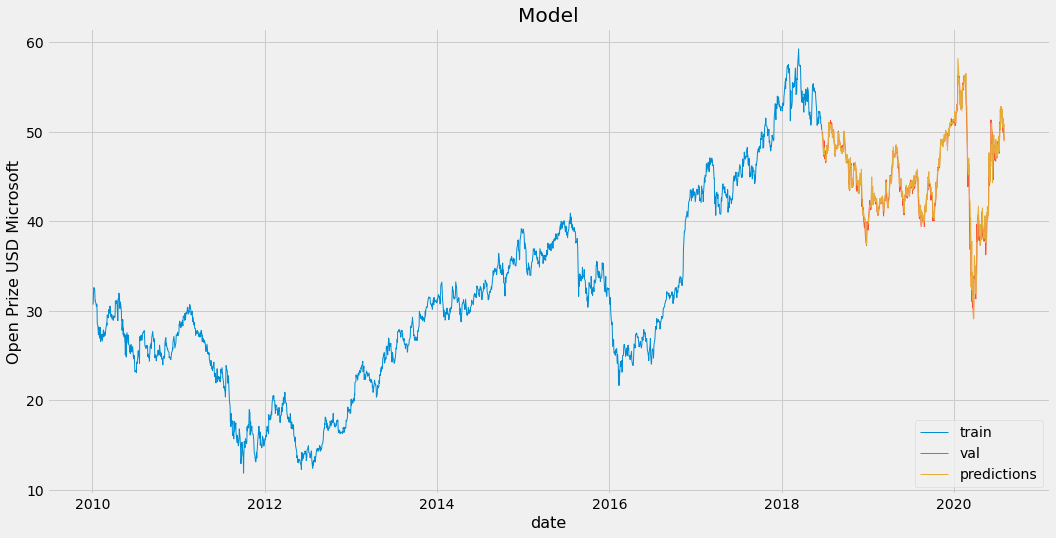

In [20]:
data=df.filter(["Open"])
train=data[:TrainDataLen]
valid=data[TrainDataLen:]
valid["predictions"]=pred
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("date", fontsize=16)
plt.ylabel("Open Prize USD Microsoft", fontsize=16)
plt.plot(train["Open"],linewidth=1)
plt.plot(valid[["Open", "predictions"]],linewidth=1)
plt.legend(["train", "val", "predictions"], loc="lower right")
plt.show()

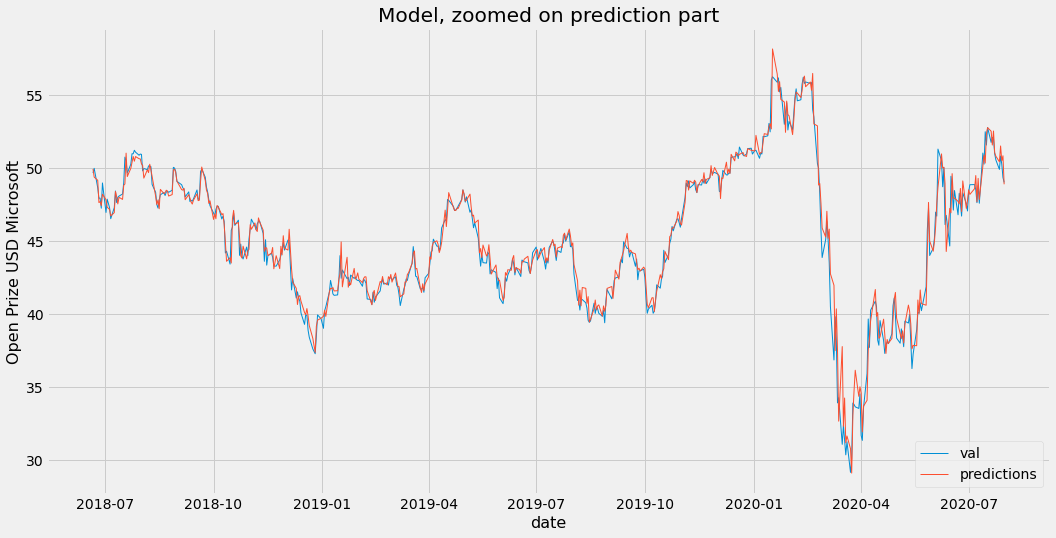

In [21]:
#zoomed in on new data
plt.figure(figsize=(16,8))
plt.ylabel("Open Prize USD Microsoft", fontsize=16)
plt.xlabel("date", fontsize=16)
plt.title("Model, zoomed on prediction part")
plt.plot(valid[["Open", "predictions"]],linewidth=1)
plt.legend([ "val", "predictions"], loc="lower right")
plt.show()

In [22]:
valid["dif(%)"]=((valid["Open"]-valid["predictions"])/valid["Open"])*100
valid["difABS(%)"]=abs(valid["dif(%)"])
valid

,Open,predictions,dif(%),difABS(%)
Date,,,,
2018-06-21,49.660000,49.939328,-0.562481,0.562481
2018-06-22,49.980000,49.382941,1.194596,1.194596
2018-06-25,48.650002,49.161498,-1.051381,1.051381
2018-06-26,47.939999,47.636295,0.633509,0.633509
2018-06-27,47.939999,47.699383,0.501909,0.501909
...,...,...,...,...
2020-07-27,49.910000,50.433486,-1.048861,1.048861
2020-07-28,50.830002,51.514561,-1.346762,1.346762
2020-07-29,50.270000,50.499980,-0.457488,0.457488


In [23]:
valid.describe()

,Open,predictions,dif(%),difABS(%)
count,532.000000,532.000000,532.000000,532.000000
mean,45.062011,45.240345,-0.463446,1.274675
std,4.813484,4.655918,2.094250,1.724301
min,29.150000,29.099173,-21.560434,0.000387
25%,41.980000,42.177321,-1.179879,0.358859
50%,44.650002,44.737004,-0.228541,0.782238
75%,48.500000,48.511438,0.457633,1.570404
max,56.259998,58.163016,6.006132,21.560434


filtering pre Covid-19 lockdown data

In [24]:
preCovid=valid["2018-06-21":"2020-02-1"] #the date is a point before the big decline
preCovid

,Open,predictions,dif(%),difABS(%)
Date,,,,
2018-06-21,49.660000,49.939328,-0.562481,0.562481
2018-06-22,49.980000,49.382941,1.194596,1.194596
2018-06-25,48.650002,49.161498,-1.051381,1.051381
2018-06-26,47.939999,47.636295,0.633509,0.633509
2018-06-27,47.939999,47.699383,0.501909,0.501909
...,...,...,...,...
2020-01-27,53.000000,54.524317,-2.876069,2.876069
2020-01-28,53.799999,52.448327,2.512401,2.512401
2020-01-29,54.480000,54.590680,-0.203158,0.203158


In [25]:
preCovid.describe()

,Open,predictions,dif(%),difABS(%)
count,406.000000,406.000000,406.000000,406.000000
mean,45.389877,45.500433,-0.272098,0.900448
std,3.737247,3.629844,1.222503,0.869440
min,37.279999,37.367611,-5.870733,0.000387
25%,42.452500,42.592843,-0.986312,0.290468
50%,44.600000,44.645181,-0.195381,0.604469
75%,48.340000,48.231261,0.420088,1.270916
max,56.259998,58.163016,6.006132,6.006132


# Feedback/Notes version 2
I wanted to predict the open column and used all data for the input, not just the same column. <br>
The predictive qualities of the model seem to have worsened with the new data. <br>
- with 128 and 50 neurons 10epoches: max error < 21%
- with 128\*2 and 50\*2 neurons 10epoches: max error  <22

Obviously it is especially hard to predict stock pirces when something very unlikely/something noone expected happenes, like a global pandemic.

# Feedback/Notes version 1 (see Github vers)
Apple:
being 3.3%of on average is way to high for a stock environment. (apple   code = AAPL, Apple1.h5)

Microsoft: mean dif is better with MS, but a max dif of over 15% is way to huge. (Microsoft code=MS, MS1.h5)